# NDVI timeseries for Ord Irrigation Scheme <img align="right" src="../Supplementary_data/dea_logo.jpg">

[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Examine spatiotemporal trends in Ord River NDVI.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

from IPython.display import Image
from datacube.utils.geometry import Geometry, CRS
from dea_tools.plotting import display_map, xr_animation, map_shapefile
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from dea_tools.spatial import xr_rasterize
from datacube.utils.cog import write_cog

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Ord_NDVI')

In [3]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41453 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35471 Dashboard: /user/mickwelli/proxy/41453/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


In [4]:
area = gpd.read_file('data/Ord_peren_ann.shp').to_crs("epsg:6933")
area

,id,geometry
0,1,"POLYGON ((12424074.451 -1971072.352, 12424992...."


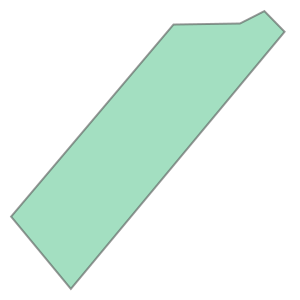

In [5]:
geom = Geometry(geom=area.iloc[0].geometry, crs="epsg:6933")
geom

In [6]:
map_shapefile(area, attribute = area.columns[0])

/home/jovyan/Tools/dea_tools/plotting.py:418: FutureWarning: The `map_shapefile` function is deprecated, and will be removed from future versions of `dea-tools`. Please use Geopanda's built-in `.explore` functionality instead.
  warnings.warn("The `map_shapefile` function is deprecated, and will "


Label(value='')

Map(center=[-15.635903265556818, 128.7732064740411], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [7]:
time = ('2013-01-01', '2021-12-31')

products = ['ga_ls8c_ard_3']

output_crs = 'epsg:6933'

In [8]:
ds = load_ard(dc=dc, 
              products=products,
              min_gooddata=0.99, 
              measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir','nbart_swir_1', 'nbart_swir_2'],
              output_crs=output_crs,
              time = time,
              resolution = (-30,30),
              geopolygon = geom,
              group_by = 'solar_day',
              dask_chunks={'x': 3000, 'y': 3000})

/home/jovyan/Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 144 out of 197 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Returning 144 time steps as a dask array


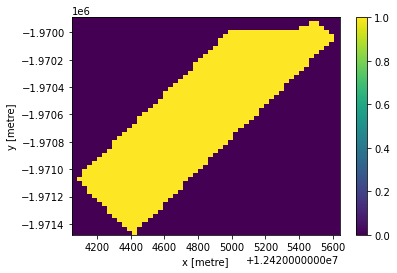

In [9]:
mask = xr_rasterize(area.iloc[[0]], ds)

# Plot the mask
mask.plot()

In [10]:
ds_masked = ds.where(mask)

In [11]:
NDVI = calculate_indices(ds_masked, index="NDVI", collection = 'ga_ls_3')

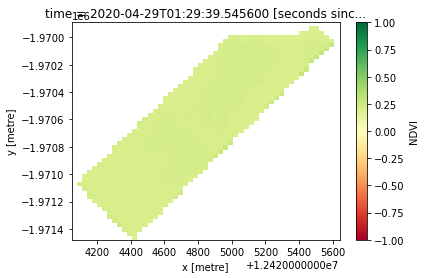

In [12]:
NDVI.NDVI[110].plot(vmin=-1, vmax=1, cmap='RdYlGn')

Exporting animation to NDVI_Ord_monthxyear.gif


  0%|          | 0/144 (0.0 seconds remaining at ? frames/s)

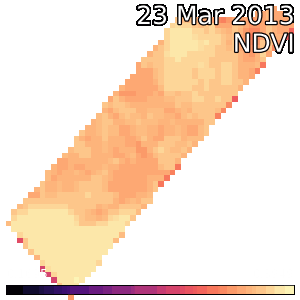

In [13]:
xr_animation(ds=NDVI,
             bands=['NDVI'], 
             output_path='NDVI_Ord_monthxyear.gif',
             width_pixels=300,
             show_text='NDVI',
             percentile_stretch=(0.01, 0.99),
             interval=400,
             annotation_kwargs={'fontsize': 25}) 

# Plot animated gif
plt.close()
Image(filename='NDVI_Ord_monthxyear.gif')

Exporting animation to RGB_Ord_monthxyear.gif


  0%|          | 0/144 (0.0 seconds remaining at ? frames/s)

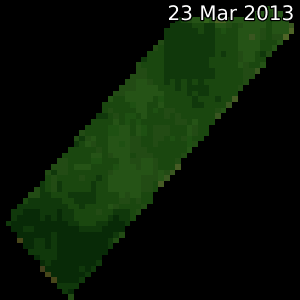

In [14]:
xr_animation(ds=ds_masked, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='RGB_Ord_monthxyear.gif',                                
             width_pixels=300,
             interval=400) 

# Plot animated gif
plt.close()
Image(filename='RGB_Ord_monthxyear.gif')

In [15]:
for i in range(len(NDVI.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = ds.isel(time=i).time.dt.strftime('%Y-%m-%d').data
    print(f'Writing {date}')
    
    # Convert current time step into a `xarray.DataArray`
    singleTimestamp = ds.isel(time=i).to_array()

    # Write GeoTIFF  
    write_cog(singleTimestamp,
              fname=f'Ord_monthxyear_{date}.tif',
              overwrite=True).compute()

Writing 2013-03-23
Writing 2013-04-26
Writing 2013-05-12
Writing 2013-05-28
Writing 2013-06-13
Writing 2013-06-29
Writing 2013-07-15
Writing 2013-07-31
Writing 2013-08-16
Writing 2013-09-01
Writing 2013-09-17
Writing 2013-10-19
Writing 2013-11-04
Writing 2014-01-07
Writing 2014-03-12
Writing 2014-03-28
Writing 2014-04-13
Writing 2014-06-16
Writing 2014-07-02
Writing 2014-07-18
Writing 2014-08-03
Writing 2014-08-19
Writing 2014-09-04
Writing 2014-09-20
Writing 2014-10-06
Writing 2014-10-22
Writing 2014-11-07
Writing 2014-11-23
Writing 2015-01-10
Writing 2015-03-15
Writing 2015-04-16
Writing 2015-05-02
Writing 2015-05-18
Writing 2015-06-03
Writing 2015-06-19
Writing 2015-07-05
Writing 2015-07-21
Writing 2015-08-06
Writing 2015-08-22
Writing 2015-09-07
Writing 2015-09-23
Writing 2015-10-09
Writing 2015-10-25
Writing 2015-11-26
Writing 2015-12-28
Writing 2016-02-14
Writing 2016-03-01
Writing 2016-03-17
Writing 2016-04-02
Writing 2016-04-18
Writing 2016-05-04
Writing 2016-06-05
Writing 2016

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)